# Statistical maps with smooth beta series

- We plot the `t statistics` and use the `p values` for thresholding.


- We get the `t statistics` through applying a t test.

---

`stats.ttest_1samp` replicates the matlab [ttest(x) function](https://www.mathworks.com/help/stats/ttest.html#btrj1bc):
(One-sample t-test)

- H0: data in x comes from a normal distribution with mean equal to zero (`popmean=0`) and unknown variance, using the one-sample t-test.
- HA: population distribution does not have a mean equal to zero. The result h is 1 if the test rejects the null hypothesis at the 5% significance level, and 0 otherwise.

--- 



In [1]:
import h5py
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets, image
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import pandas as pd
from importlib import reload 
import scipy.io as sio
from scipy import stats

# import own functions
import utils
reload(utils)

#%autosave 30
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

In [2]:
# specify local path
path = '/Users/Daphne/data/'

# parameters
num_subjects = 8

# # load all bold data
games_betas = np.load(path+'bold_data_games.npy')
blocks_betas = np.load(path+'bold_data_blocks.npy')
levels_betas = np.load(path+'bold_data_levels.npy')
# boxcar_betas = np.load(path+'bold_data_boxcar.npy')

# load mask and get voxel coordinates
mask_arr = np.load(path+'mask_arr.npy') # all masks are the same
mask_mat = mask_arr[0] # so we can pick any one from the array
coords_mat = np.array(np.where(mask_mat == 1)) # so need one set of voxel coordinates for all
coords_mat[[0, 2]] = coords_mat[[2, 0]] # exchange the rows

'''load brain templates'''

# mask_nii is the functional mask, this selects the brain voxels
mask_nii = nib.load(os.path.join(path, 'mask.nii')) 

# we get the brain mask (boolean array) with the .dataobj method
brain_mask = np.array(mask_nii.dataobj)

# Get the list of nonzero voxel coordinates from the nii mask
coords_nii = np.where(brain_mask)

# this where we plot our mask ON (sometimes called brain_nii) - the anatomical/structural image
mean_nii = nib.load(os.path.join(path, 'mean.nii')) 

# nosmooth betas mask, has less voxels than mask_nii
nosmooth_mask_nii = nib.load(os.path.join(path, 'mask_nosmooth.nii'))

## Load in the r values

In [3]:
iscs_p_games = np.load(path+'iscs_p_games.npy')
iscs_r_games = np.load(path+'iscs_r_games.npy')

iscs_p_blocks = np.load(path+'iscs_p_blocks.npy')
iscs_r_blocks = np.load(path+'iscs_r_blocks.npy')

iscs_p_levels = np.load(path+'iscs_p_levels.npy')
iscs_r_levels = np.load(path+'iscs_r_levels.npy')

## Get a surface from nilearn

In [4]:
# get a surface for all surface plots
fsaverage = datasets.fetch_surf_fsaverage5()

# 1. ISC t maps (games, slide 361)

---

used the same coordinate cut as in the slides from Momchil.

---

In [5]:
tstats_games, p_games = stats.ttest_1samp(np.arctanh(iscs_r_games), popmean=0) # do the ttest

Display t statistics with a corresponding p < 0.05


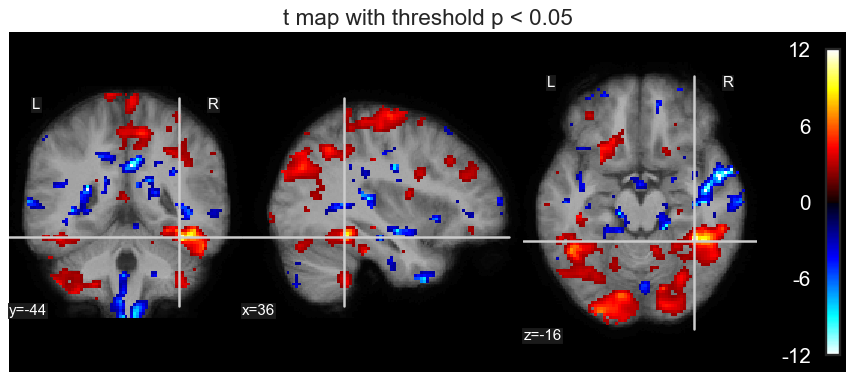

In [6]:
utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats_games, 
                           pvalues=p_games, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.05,
                           cut_coords=[36, -44, -16],
                           vmax=12)

Display t statistics with a corresponding p < 0.01


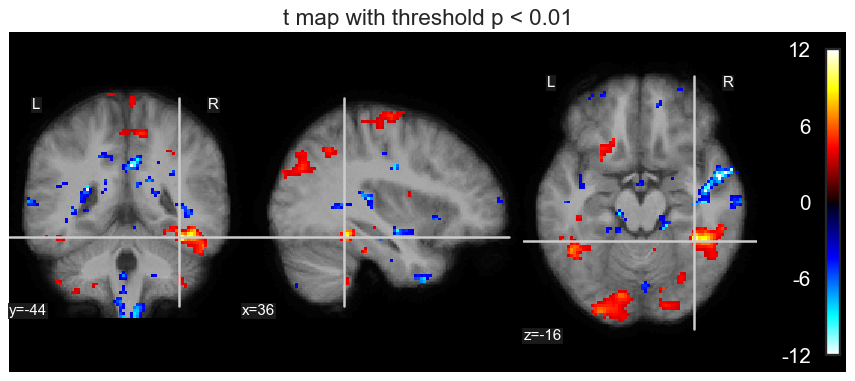

In [7]:
utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats_games, 
                           pvalues=p_games, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[36, -44, -16],
                           vmax=12)

In [8]:
isc_nifti_games = utils.prep_for_surface_plot(coords=coords_mat, 
                                              tstats=tstats_games, 
                                              pvalues=p_games, 
                                              brain_nii=mean_nii, 
                                              mask_nii=mask_nii,
                                              theta=0.01
                                             )

# Make a "texture" with isc_nifti (NOTE: need to make a different for left and right!)
texture_left = surface.vol_to_surf(isc_nifti_games, fsaverage.pial_left) 
texture_right = surface.vol_to_surf(isc_nifti_games, fsaverage.pial_right) 

Use t statistics with a corresponding p < 0.01


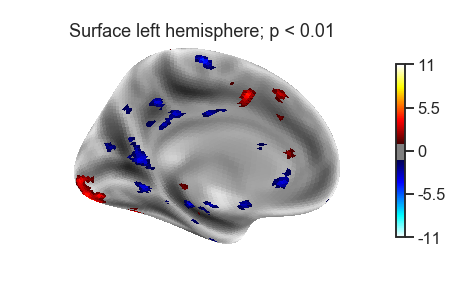

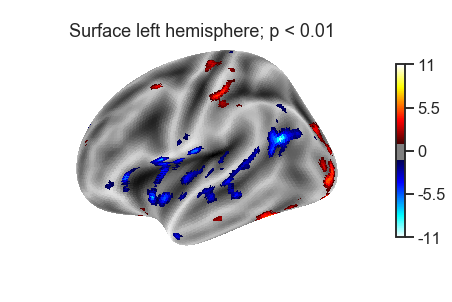

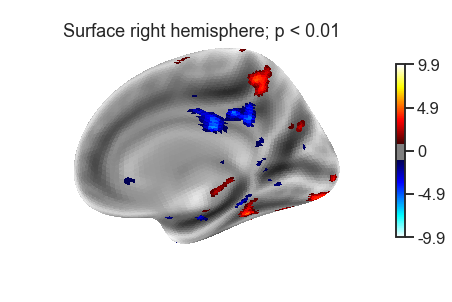

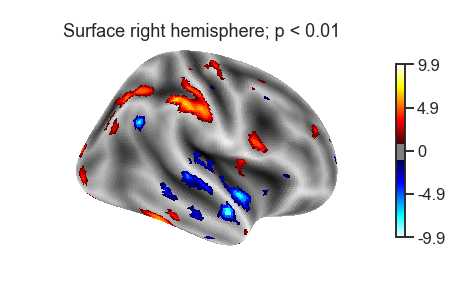

In [9]:
surf_map_left_medial = plotting.plot_surf_stat_map(
                                fsaverage.infl_left, 
                                texture_left, 
                                hemi='left', 
                                view='medial',
                                title='Surface left hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_left)

surf_map_left_lateral = plotting.plot_surf_stat_map(
                                fsaverage.infl_left, 
                                texture_left, 
                                hemi='left', 
                                view='lateral', 
                                title='Surface left hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_left)

surf_map_right_medial = plotting.plot_surf_stat_map(
                                fsaverage.infl_right, 
                                texture_right, 
                                hemi='right', 
                                view='medial', 
                                title='Surface right hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_right)

surf_map_right_lateral = plotting.plot_surf_stat_map(
                                fsaverage.infl_right, 
                                texture_right, 
                                hemi='right', 
                                view='lateral', 
                                title='Surface right hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_right)

# 3. ISC t map (blocks, slide 362)

In [10]:
tstats_blocks, p_blocks = stats.ttest_1samp(np.arctanh(iscs_r_blocks), popmean=0)

Display t statistics with a corresponding p < 0.05


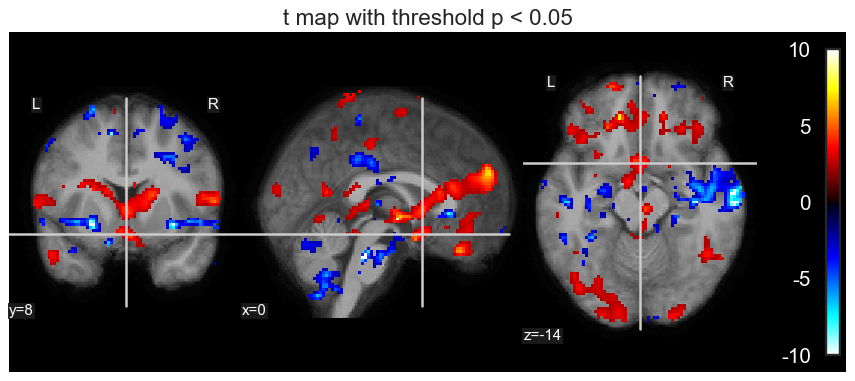

In [11]:
utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats_blocks, 
                           pvalues=p_blocks, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.05,
                           cut_coords=[0, 8, -14],
                           vmax=10)

Display t statistics with a corresponding p < 0.01


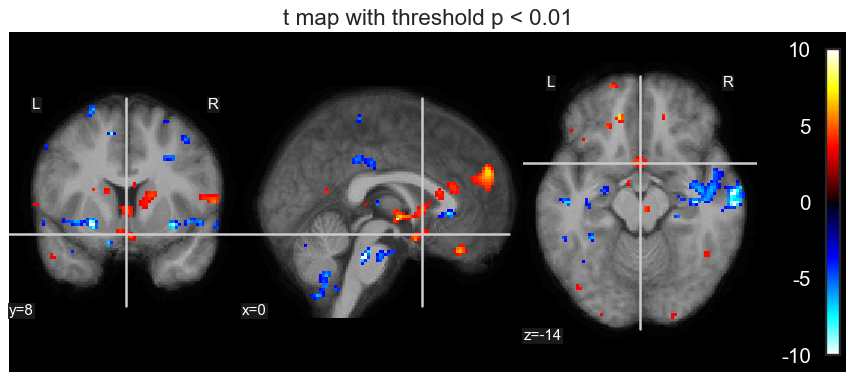

In [12]:
utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats_blocks, 
                           pvalues=p_blocks, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[0, 8, -14],
                           vmax=10)

## Surface plots

In [13]:
isc_nifti_blocks = utils.prep_for_surface_plot(coords=coords_mat, 
                                              tstats=tstats_blocks, 
                                              pvalues=p_blocks, 
                                              brain_nii=mean_nii, 
                                              mask_nii=mask_nii,
                                              theta=0.01
                                             )

# Make a "texture" with isc_nifti (NOTE: need to make a different for left and right!)
texture_left = surface.vol_to_surf(isc_nifti_blocks, fsaverage.pial_left) 
texture_right = surface.vol_to_surf(isc_nifti_blocks, fsaverage.pial_right) 

Use t statistics with a corresponding p < 0.01


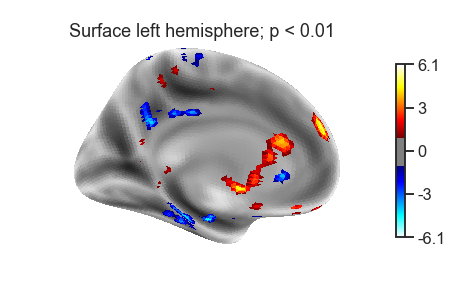

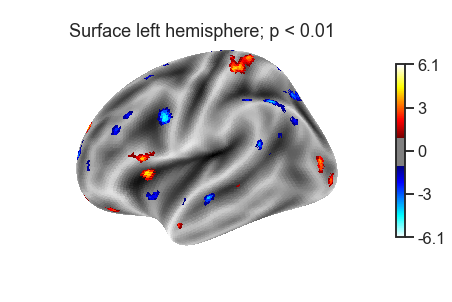

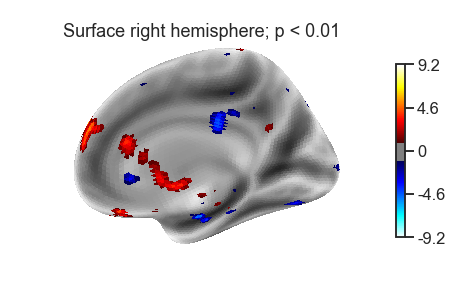

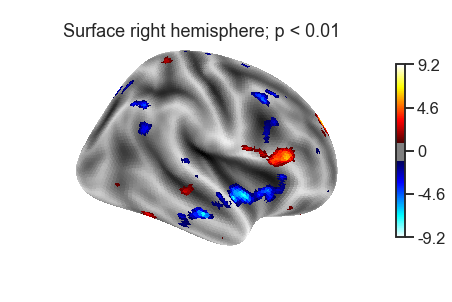

In [14]:
surf_map_left_medial = plotting.plot_surf_stat_map(
                                fsaverage.infl_left, 
                                texture_left, 
                                hemi='left', 
                                view='medial',
                                title='Surface left hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_left)

surf_map_left_lateral = plotting.plot_surf_stat_map(
                                fsaverage.infl_left, 
                                texture_left, 
                                hemi='left', 
                                view='lateral', 
                                title='Surface left hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_left)

surf_map_right_medial = plotting.plot_surf_stat_map(
                                fsaverage.infl_right, 
                                texture_right, 
                                hemi='right', 
                                view='medial', 
                                title='Surface right hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_right)

surf_map_right_lateral = plotting.plot_surf_stat_map(
                                fsaverage.infl_right, 
                                texture_right, 
                                hemi='right', 
                                view='lateral', 
                                title='Surface right hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_right)

# 3. ISC t map (levels, slide 363)

In [15]:
tstats_levels, p_levels = stats.ttest_1samp(np.arctanh(iscs_r_levels), popmean=0)

Display t statistics with a corresponding p < 0.05


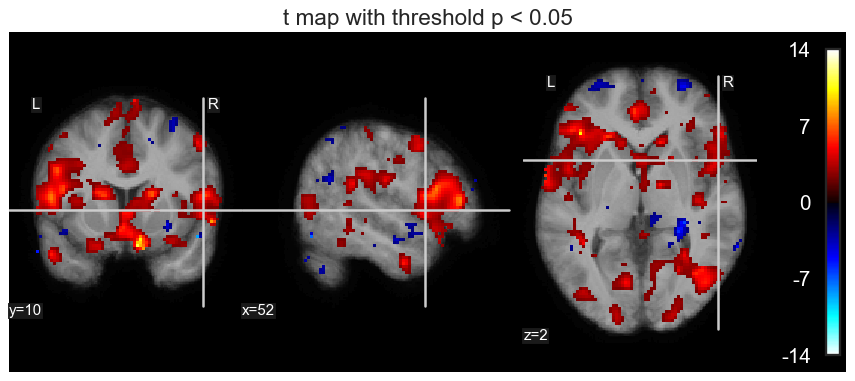

In [16]:
utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats_levels, 
                           pvalues=p_levels, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.05,
                           cut_coords=[52, 10, 2],
                           vmax=14)

Display t statistics with a corresponding p < 0.01


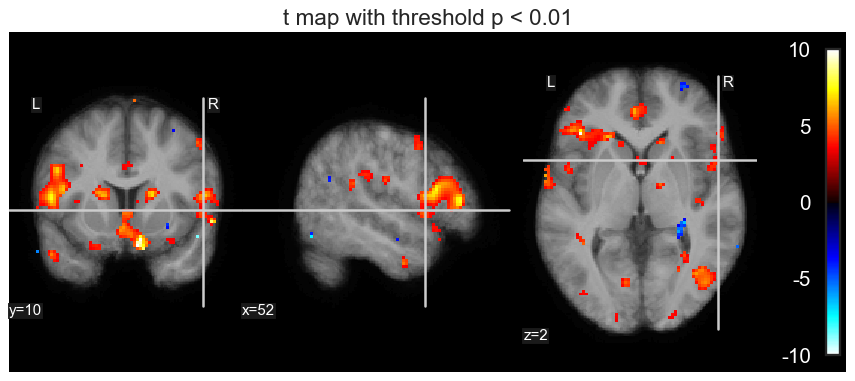

In [17]:
utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats_levels, 
                           pvalues=p_levels, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[52, 10, 2],
                           vmax=10)

In [18]:
isc_nifti_levels = utils.prep_for_surface_plot(coords=coords_mat, 
                                               tstats=tstats_levels, 
                                               pvalues=p_levels, 
                                               brain_nii=mean_nii, 
                                               mask_nii=mask_nii,
                                               theta=0.01
                                               )

# Make a "texture" with isc_nifti (NOTE: need to make a different for left and right!)
texture_left = surface.vol_to_surf(isc_nifti_levels, fsaverage.pial_left) 
texture_right = surface.vol_to_surf(isc_nifti_levels, fsaverage.pial_right) 

Use t statistics with a corresponding p < 0.01


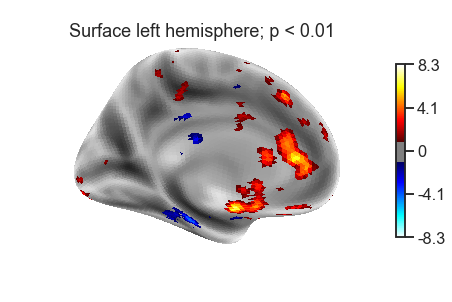

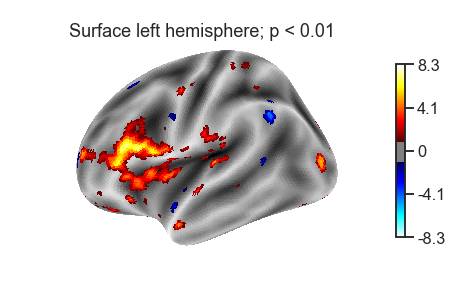

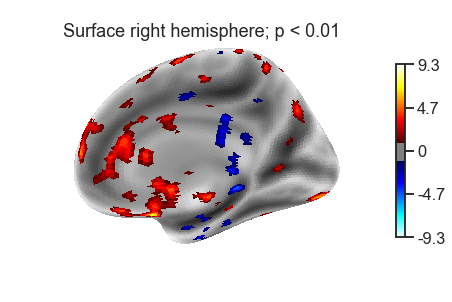

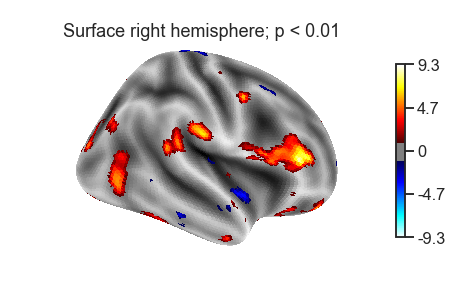

In [19]:
surf_map_left_medial = plotting.plot_surf_stat_map(
                                fsaverage.infl_left, 
                                texture_left, 
                                hemi='left', 
                                view='medial',
                                title='Surface left hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_left)

surf_map_left_lateral = plotting.plot_surf_stat_map(
                                fsaverage.infl_left, 
                                texture_left, 
                                hemi='left', 
                                view='lateral', 
                                title='Surface left hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_left)

surf_map_right_medial = plotting.plot_surf_stat_map(
                                fsaverage.infl_right, 
                                texture_right, 
                                hemi='right', 
                                view='medial', 
                                title='Surface right hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_right)

surf_map_right_lateral = plotting.plot_surf_stat_map(
                                fsaverage.infl_right, 
                                texture_right, 
                                hemi='right', 
                                view='lateral', 
                                title='Surface right hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_right)